In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-mar-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2022/train.csv
/kaggle/input/tabular-playground-series-mar-2022/test.csv


# Tabular Playground Series - Feb 2022

The tabular series on kaggle was developed withthe aim to help novices in data science field to get acquainted with kaggle competitions.

For the March edition of the 2022 Tabular Playground Series we're challenged to forecast twelve-hours of traffic flow in a U.S. metropolis. The time series in this dataset are labelled with both location coordinates and a direction of travel -- a combination of features that will test your skill at spatio-temporal forecasting within a highly dynamic traffic network.

Models must be evaluated on the mean absolute error between predicted and actual congestion values for each time period in the test set.

<h2>Exploratory Data Analysis</h2>


<h3>Train dataset</h3>

Lets first explore the train dataset and subsequently the test dataset.


In [2]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2022/train.csv')

In [3]:
train_df.head()

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60


In [4]:
train_df.tail()

,row_id,time,x,y,direction,congestion
848830,848830,1991-09-30 11:40:00,2,3,NB,54
848831,848831,1991-09-30 11:40:00,2,3,NE,28
848832,848832,1991-09-30 11:40:00,2,3,SB,68
848833,848833,1991-09-30 11:40:00,2,3,SW,17
848834,848834,1991-09-30 11:40:00,2,3,WB,24


In [5]:
train_df.drop('row_id', axis=1, inplace=True)

<h3>1. Structure Investigation</h3>

Prior to check the content of the data in the dataframe just loaded, let’s first verify the general structure of the dataset.


In [6]:
# Dataset shape 
train_df.shape

(848835, 5)

In [7]:
pd.value_counts(train_df.dtypes)

int64     3
object    2
dtype: int64

<h4>1.1. Structure of non-numerical features</h4>

In [8]:
train_df.describe(exclude='number')

,time,direction
count,848835,848835
unique,13059,8
top,1991-04-01 00:00:00,EB
freq,65,156708


<h4>1.2. Structure of numerical features</h4>

<AxesSubplot:title={'center':'Unique Values per feature'}>

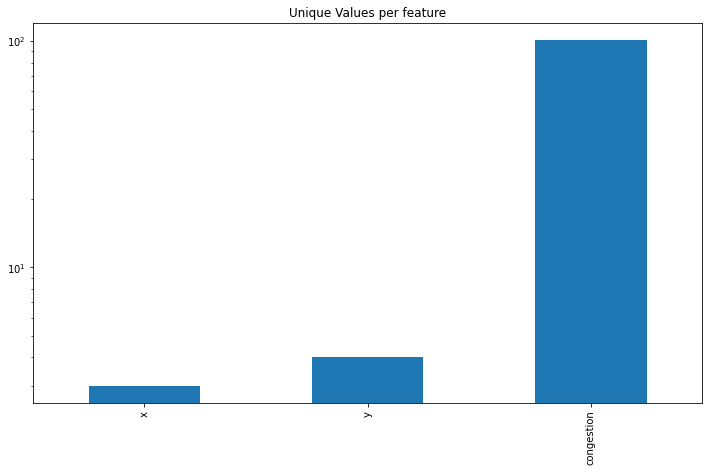

In [9]:
unique_values = train_df.select_dtypes(include='number').nunique().sort_values()

unique_values.plot.bar(logy=True, figsize=(12, 7), title='Unique Values per feature')

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848835 entries, 0 to 848834
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time        848835 non-null  object
 1   x           848835 non-null  int64 
 2   y           848835 non-null  int64 
 3   direction   848835 non-null  object
 4   congestion  848835 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 32.4+ MB


In [11]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
x,848835.0,1.138462,0.801478,0.0,0.0,1.0,2.0,2.0
y,848835.0,1.630769,1.089379,0.0,1.0,2.0,3.0,3.0
congestion,848835.0,47.815305,16.799392,0.0,35.0,47.0,60.0,100.0


<h4>1.3. Conclusion of structure investigation</h4>

The dataset being explored have very few features (5 only) to deal with and a lot of samples roughly 849k without any missing value. There are 3 features of type int64 and 2 of type object. One of these features (<b>time</b>) is a time feature, which have about 13059 unique values, meanwhile the other object feature (direction) have only 8 unique values.

The numerical features x and y have less than 10^1 unique values. On the other hand, the congestion feature (our target) has about 10^2 unique values.

<h3>2. Quality Investigation</h3>

Before proceed cehcking the content these features have, we are going to initially take a look at the general quality of the dataset.

<h4>2.1. Duplicates</h4>

In [12]:
n_duplicates = train_df.duplicated().sum()
print(f"There are {n_duplicates} duplicates samples.")

There are 0 duplicates samples.


<h4>2.2. Missing values</h4>

<h5>2.2.1. Per sample</h5>

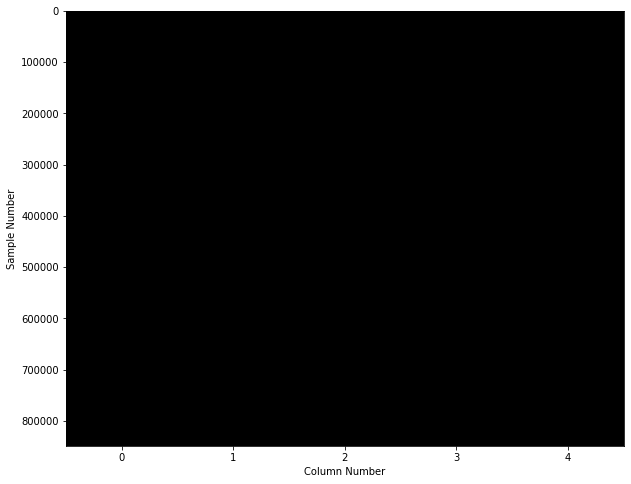

In [13]:
plt.figure(figsize=(10, 8))
plt.imshow(train_df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");

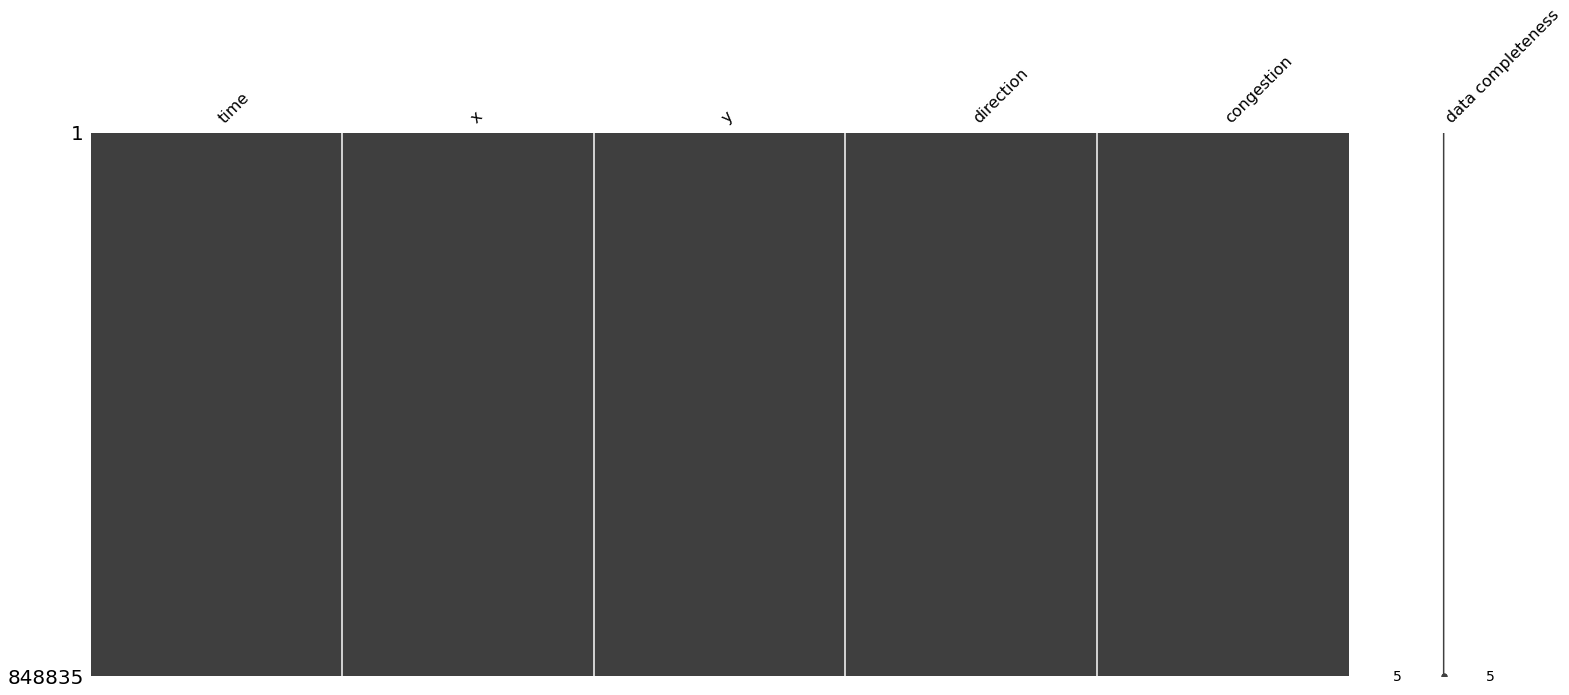

In [14]:
msno.matrix(train_df, labels=True, sort="descending");

<h5>2.2.2. Per Feature</h5>

<AxesSubplot:title={'center':'Percentage of missing values per feature'}, ylabel='Ratio of missing values per feature'>

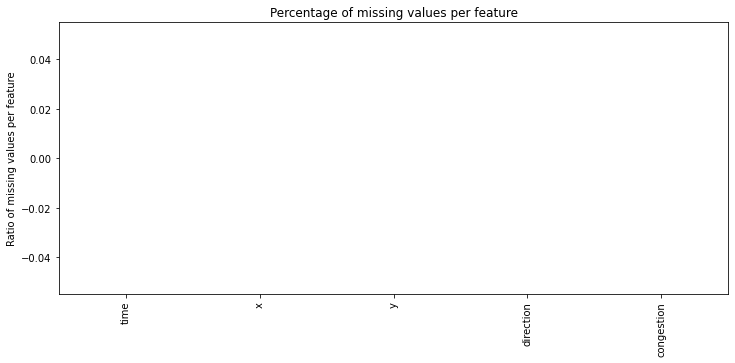

In [15]:
train_df.isna().mean().sort_values().plot(
    kind='bar', figsize=(12, 5),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature")

<h4>2.3. Unwanted entries and recording errors</h4>

<h5>2.3.1. Numerical features</h5>

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

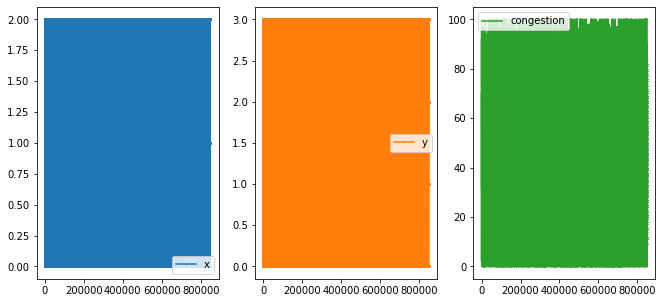

In [16]:
train_df.plot(marker='.', subplots=True, layout=(-1, 4), figsize=(15, 5), markersize=1)

<h5>2.3.2. Non-numerical features</h5>

In [17]:
train_df.describe(exclude=['number']).T

,count,unique,top,freq
time,848835,13059,1991-04-01 00:00:00,65
direction,848835,8,EB,156708


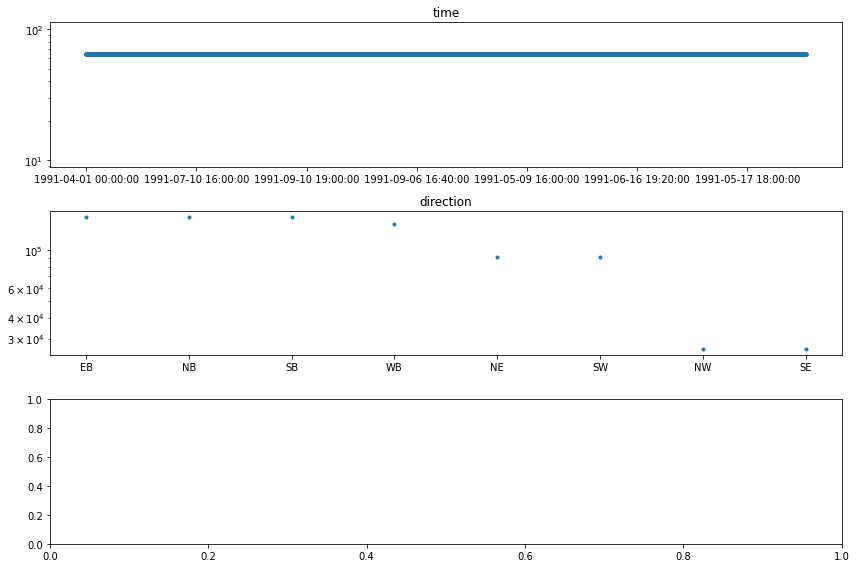

In [18]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(12, 8))
df_non_numerical = train_df.select_dtypes(exclude=['number'])

for col, ax in zip(df_non_numerical.columns, axes.ravel()):
    df_non_numerical[col].value_counts().plot(logy=True, title=col, lw=0, marker='.', ax=ax)
plt.tight_layout()

<h4>2.4. Conclusion of quality investigation</h4>

There are no missing values and the observations counts are near the same.

<h3>3. Content Investigation</h3>

Now we are going to take a look at the content of the data.

<h4>3.1. Feature distribution</h4>

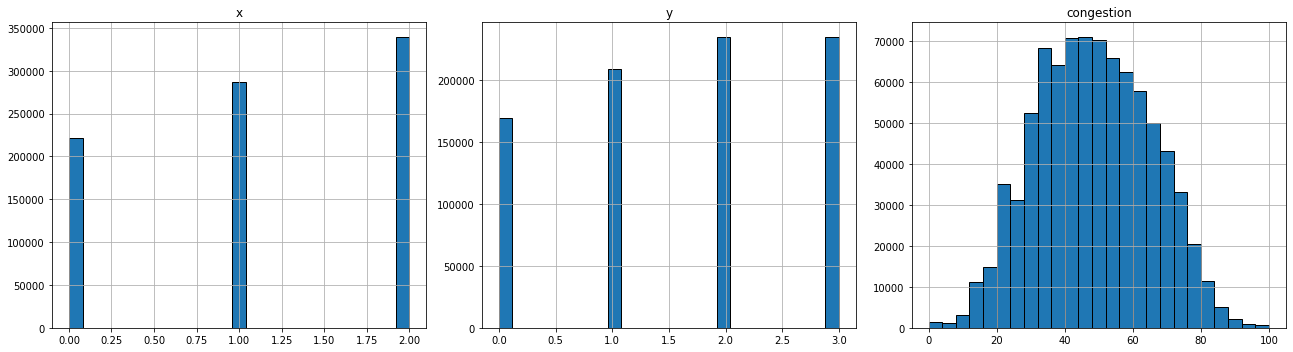

In [19]:
train_df.hist(bins=25, figsize=(30, 5), layout=(-1, 5), edgecolor='black')
plt.tight_layout()

Interestingly our response variable looks normal with mean 50.

<h4>3.2. Feature patterns</df_X[["Location_Northing_OSGR",
      "1st_Road_Number",
      "Journey_Purpose_of_Driver",
      "Pedestrian_Crossing-Physical_Facilities"]].plot(
    lw=0, marker=".", subplots=True, layout=(-1, 2),
  markersize=0.1, figsize=(15, 6));h4>

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

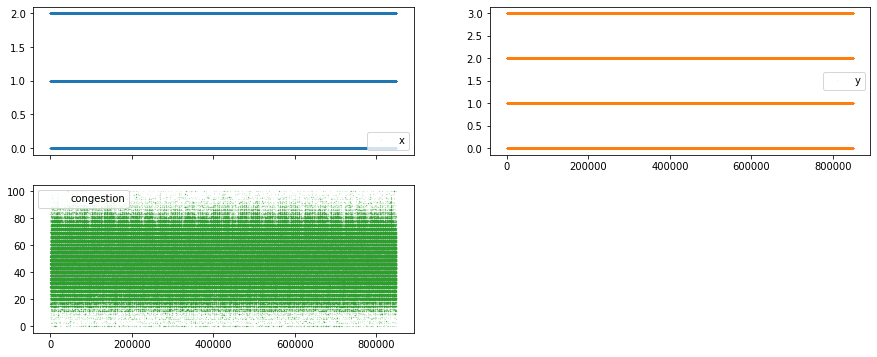

In [20]:
train_df.plot(lw=0, marker=".", subplots=True, layout=(-1, 2), markersize=0.1, figsize=(15, 6))

<h4>3.3. Feature Relationship</h4>

<AxesSubplot:>

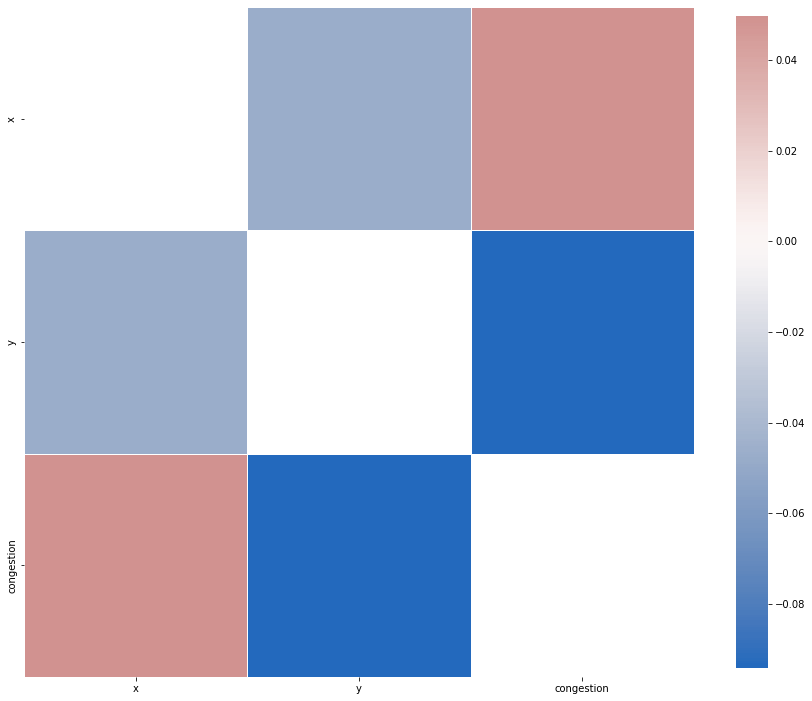

In [21]:
df_corr = train_df.corr(method="pearson")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))

sns.heatmap(df_corr, mask=np.eye(len(df_corr)),
            square=True,
            center=0,
            annot=labels,
            fmt='',
            linewidths=0.5,
            cmap="vlag",
            cbar_kws={"shrink": 0.8}
           )

<h2>Exploratory Data Analysis</h2>


<h3>Test dataset</h3>


In [22]:
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2022/test.csv')

In [23]:
test_df.head()

,row_id,time,x,y,direction
0,848835,1991-09-30 12:00:00,0,0,EB
1,848836,1991-09-30 12:00:00,0,0,NB
2,848837,1991-09-30 12:00:00,0,0,SB
3,848838,1991-09-30 12:00:00,0,1,EB
4,848839,1991-09-30 12:00:00,0,1,NB


In [24]:
test_df.tail()

,row_id,time,x,y,direction
2335,851170,1991-09-30 23:40:00,2,3,NB
2336,851171,1991-09-30 23:40:00,2,3,NE
2337,851172,1991-09-30 23:40:00,2,3,SB
2338,851173,1991-09-30 23:40:00,2,3,SW
2339,851174,1991-09-30 23:40:00,2,3,WB


In [25]:
test_df.drop('row_id', axis=1, inplace=True)

<h3>1. Structure Investigation</h3>

Prior to check the content of the data in the dataframe just loaded, let’s first verify the general structure of the dataset.


In [26]:
# Dataset shape 
test_df.shape

(2340, 4)

In [27]:
pd.value_counts(test_df.dtypes)

object    2
int64     2
dtype: int64

<h4>1.1. Structure of non-numerical features</h4>

In [28]:
test_df.describe(exclude='number')

,time,direction
count,2340,2340
unique,36,8
top,1991-09-30 12:00:00,EB
freq,65,432


<h4>1.2. Structure of numerical features</h4>

<AxesSubplot:title={'center':'Unique Values per feature'}>

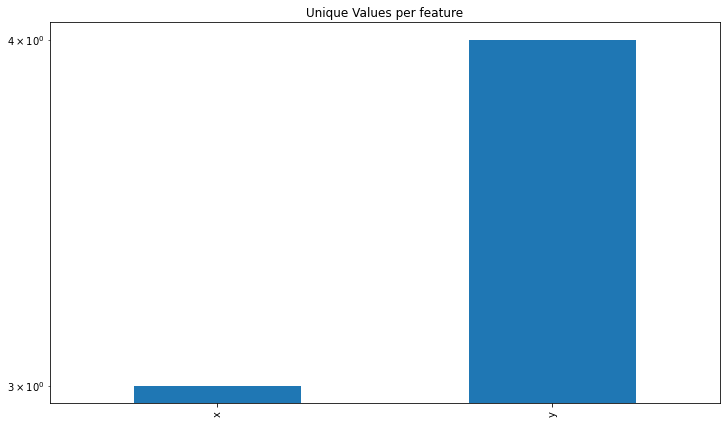

In [29]:
unique_values = test_df.select_dtypes(include='number').nunique().sort_values()

unique_values.plot.bar(logy=True, figsize=(12, 7), title='Unique Values per feature')

In [30]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   time       2340 non-null   object
 1   x          2340 non-null   int64 
 2   y          2340 non-null   int64 
 3   direction  2340 non-null   object
dtypes: int64(2), object(2)
memory usage: 73.2+ KB


In [31]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
x,2340.0,1.138462,0.801649,0.0,0.0,1.0,2.0,2.0
y,2340.0,1.630769,1.089611,0.0,1.0,2.0,3.0,3.0


<h4>1.3. Conclusion of structure investigation</h4>

The test dataset being explored have very few features (4 only) to deal with and very few samples 2340 only without any missing value. There are 2 features of type int64 and 2 of type object. One of these features (<b>time</b>) is a time feature, which have about 13059 unique values, meanwhile the other object feature (direction) have only 8 unique values.

The numerical features x and y have less than 10^1 unique values. On the other hand, the congestion feature (our target) has about 10^2 unique values.

<h3>2. Quality Investigation</h3>

Before proceed cehcking the content these features have, we are going to initially take a look at the general quality of the dataset.

<h4>2.1. Duplicates</h4>

In [32]:
n_duplicates = test_df.duplicated().sum()
print(f"There are {n_duplicates} duplicates samples.")

There are 0 duplicates samples.


<h4>2.2. Missing values</h4>

<h5>2.2.1. Per sample</h5>

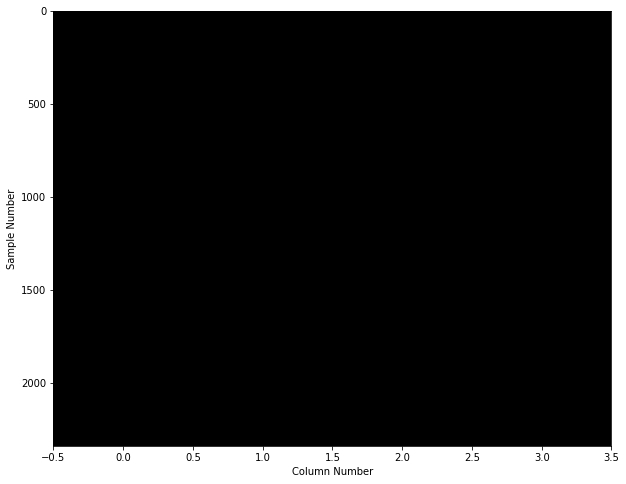

In [33]:
plt.figure(figsize=(10, 8))
plt.imshow(test_df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");

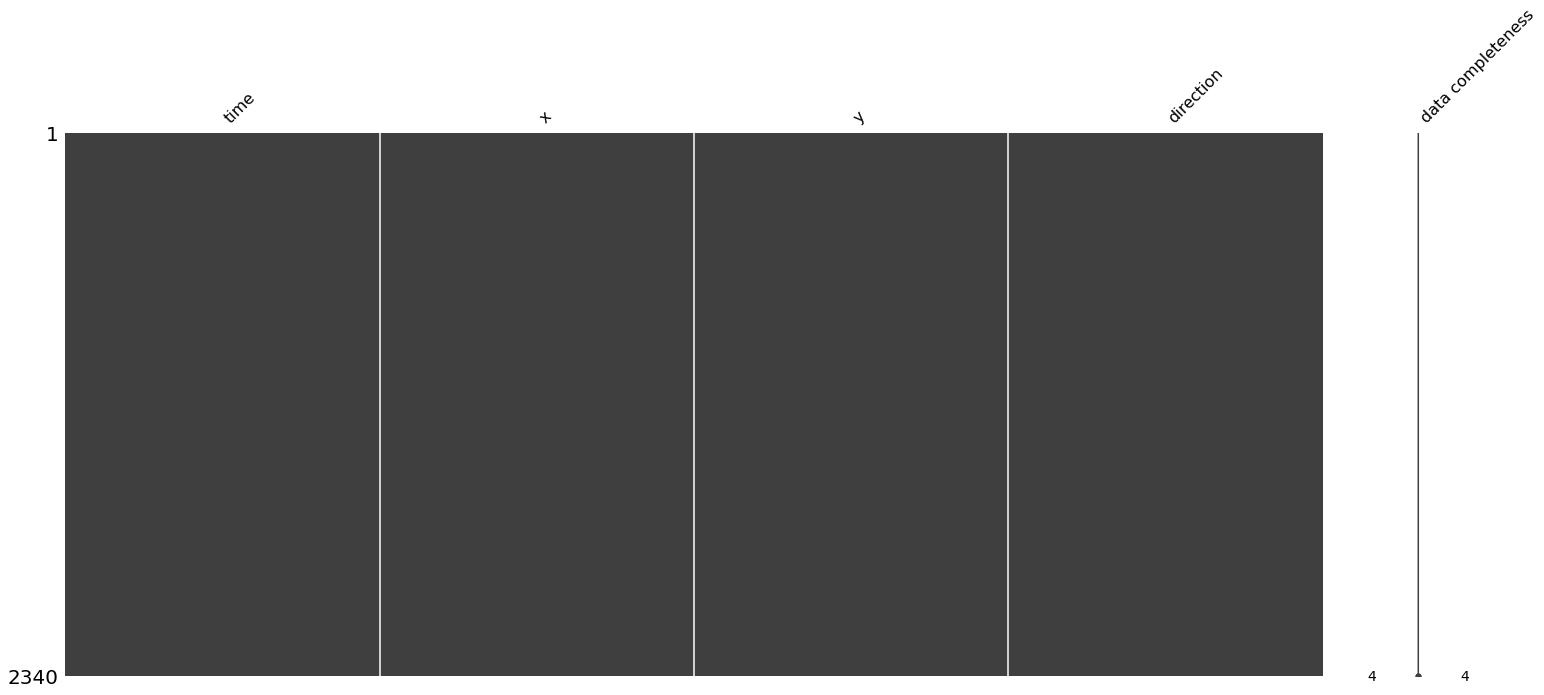

In [34]:
msno.matrix(test_df, labels=True, sort="descending");

<h5>2.2.2. Per Feature</h5>

<AxesSubplot:title={'center':'Percentage of missing values per feature'}, ylabel='Ratio of missing values per feature'>

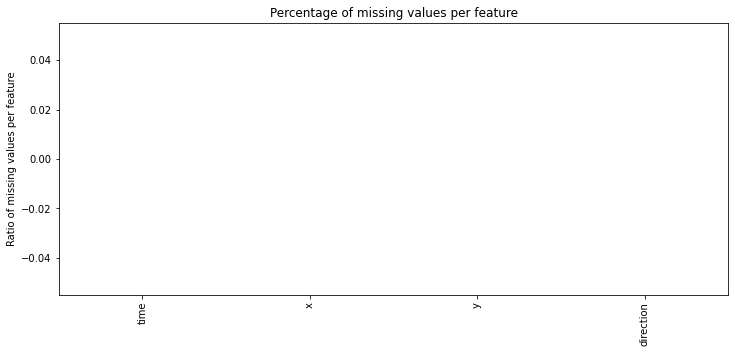

In [35]:
test_df.isna().mean().sort_values().plot(
    kind='bar', figsize=(12, 5),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature")

<h4>2.3. Unwanted entries and recording errors</h4>

<h5>2.3.1. Numerical features</h5>

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

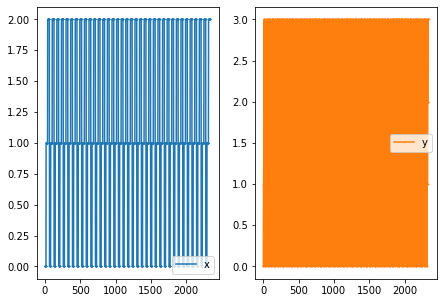

In [36]:
test_df.plot(marker='.', subplots=True, layout=(-1, 4), figsize=(15, 5), markersize=1)

<h5>2.3.2. Non-numerical features</h5>

In [37]:
test_df.describe(exclude=['number']).T

,count,unique,top,freq
time,2340,36,1991-09-30 12:00:00,65
direction,2340,8,EB,432


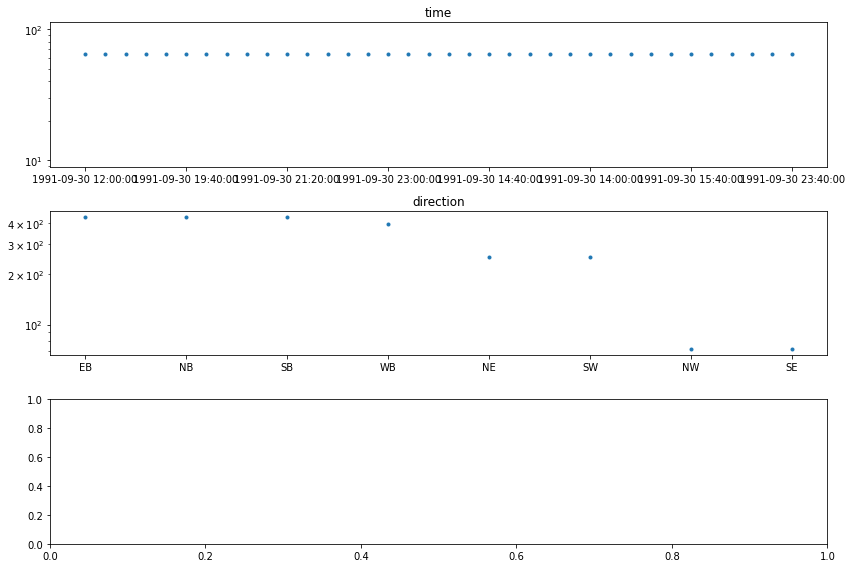

In [38]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(12, 8))
df_non_numerical = test_df.select_dtypes(exclude=['number'])

for col, ax in zip(df_non_numerical.columns, axes.ravel()):
    df_non_numerical[col].value_counts().plot(logy=True, title=col, lw=0, marker='.', ax=ax)
plt.tight_layout()

<h4>2.4. Conclusion of quality investigation</h4>

There are no missing values and the observations counts are near the same.

<h3>3. Content Investigation</h3>

Now we are going to take a look at the content of the data.

<h4>3.1. Feature distribution</h4>

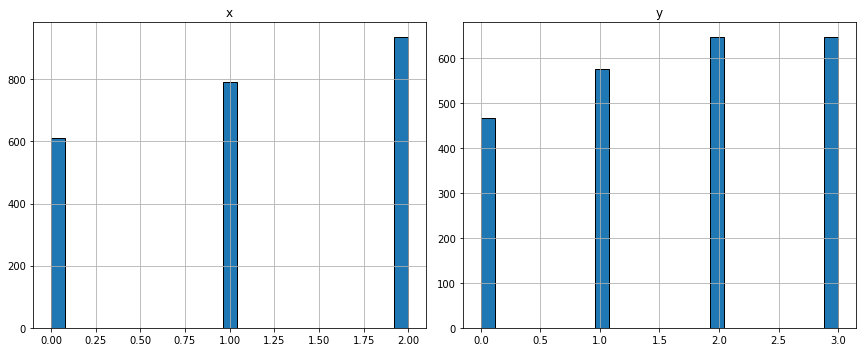

In [39]:
test_df.hist(bins=25, figsize=(30, 5), layout=(-1, 5), edgecolor='black')
plt.tight_layout()

It is very similar to the train dataset

<h4>3.2. Feature patterns</df_X[["Location_Northing_OSGR",
      "1st_Road_Number",
      "Journey_Purpose_of_Driver",
      "Pedestrian_Crossing-Physical_Facilities"]].plot(
    lw=0, marker=".", subplots=True, layout=(-1, 2),
  markersize=0.1, figsize=(15, 6));h4>

array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

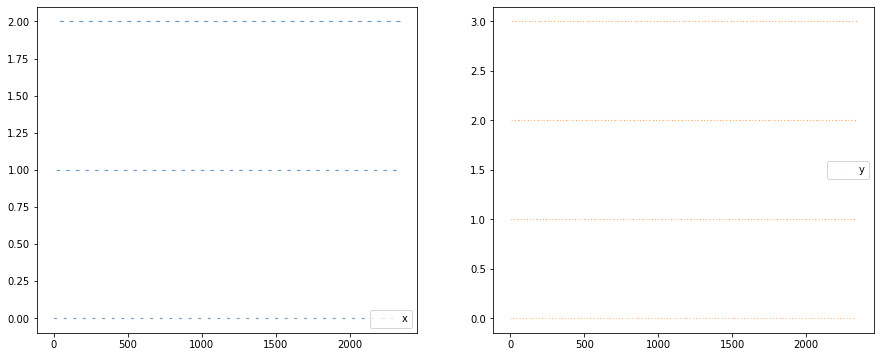

In [40]:
test_df.plot(lw=0, marker=".", subplots=True, layout=(-1, 2), markersize=0.1, figsize=(15, 6))

<h4>3.3. Feature Relationship</h4>

<AxesSubplot:>

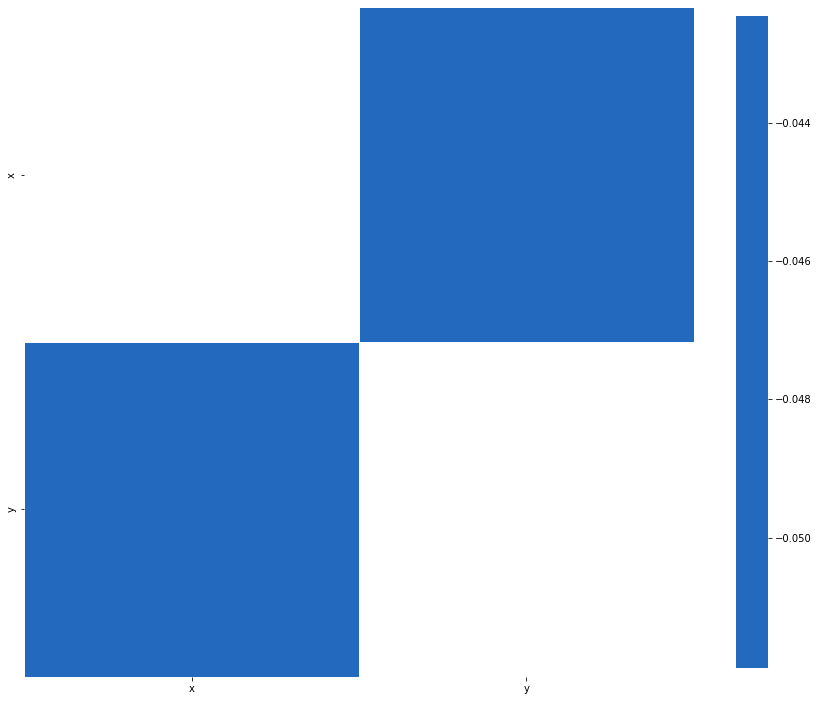

In [41]:
df_corr = test_df.corr(method="pearson")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))

sns.heatmap(df_corr, mask=np.eye(len(df_corr)),
            square=True,
            center=0,
            annot=labels,
            fmt='',
            linewidths=0.5,
            cmap="vlag",
            cbar_kws={"shrink": 0.8}
           )